In [1]:
import pandas as pd
import numpy as np
 
from typing import Dict, Any, Iterable

import matplotlib.pyplot as plt
import holidays

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

# Screener
- Equity only
- 6+ years of data (1500+ data points)

In [3]:
# load data
etf_list = context.catalog.load('etfs')
etf_information = context.catalog.load('etf_information')
etf_historic_investpy = context.catalog.load('etf_historical')
etf_historic_alpha = context.catalog.load('alphavantage_etf_historical_cleansed')

2021-06-10 20:23:10,372 - kedro.io.data_catalog - INFO - Loading data from `etfs` (CSVDataSet)...
2021-06-10 20:23:10,496 - kedro.io.data_catalog - INFO - Loading data from `etf_information` (CSVDataSet)...
2021-06-10 20:23:10,660 - kedro.io.data_catalog - INFO - Loading data from `etf_historical` (PartitionedDataSet)...
2021-06-10 20:23:11,392 - kedro.io.data_catalog - INFO - Loading data from `alphavantage_etf_historical_cleansed` (PartitionedDataSet)...


In [4]:
etf_information

,ETF Name,Prev. Close,Todays Range,ROI (TTM),Open,52 wk Range,Dividends (TTM),Volume,Market Cap,Dividend Yield,Average Vol. (3m),Total Assets,Beta,1-Year Change,Shares Outstanding,Asset Class,name
0,AGPH,5.15,5.15 - 5.16,NaN,5.15,5.1 - 5.34,0.07,60933.0,NaN,1.31%,171062.0,NaN,NaN,- 1.89%,NaN,NaN,etf_AGBP_IE00BF540Y54
1,AIAG,1231.70,"1,246.2 - 1,246.2",NaN,1246.20,"855.3 - 1,456.2",NaN,3067.0,NaN,NaN,12554.0,NaN,NaN,33.16%,NaN,Equity,etf_AIAG_IE00BK5BCD43
2,AUCOP,2822.50,"2,795 - 2,831",NaN,2801.00,"2,255 - 3,461.8",NaN,10703.0,NaN,NaN,8014.0,NaN,NaN,1.79%,NaN,Commodity,etf_AUCP_IE00B3CNHG25
3,BATG,1281.60,"1,291.2 - 1,305.2",NaN,1295.40,"697.3 - 1,349",NaN,47188.0,NaN,NaN,54049.0,NaN,NaN,87.86%,NaN,Commodity,etf_BATG_IE00BF0M2Z96
4,CEU1,12203.00,"12,302 - 12,302",NaN,12302.00,"9,292 - 12,326",NaN,1197.0,NaN,NaN,4374.0,NaN,NaN,30.59%,NaN,Equity,etf_CEU1_IE00B53QG562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,XSX6,8659.50,"8,709 - 8,724",NaN,8709.00,"6,768 - 8,738",NaN,2623.0,NaN,NaN,2482.0,NaN,NaN,25.41%,NaN,Equity,etf_XSX6_LU0328475792
175,XUFB,1805.20,"1,815 - 1,825.6",NaN,1825.60,"1,079.8 - 1,835.2",NaN,6710.0,NaN,NaN,58046.0,NaN,NaN,50.82%,NaN,Equity,etf_XUFB_IE00BDVPTJ63
176,XUKS,339.08,337.3 - 337.8,NaN,337.55,333.27 - 444.75,NaN,259134.0,NaN,NaN,269563.0,NaN,NaN,- 19.14%,NaN,Equity,etf_XUKS_LU0328473581
177,XUKX,702.20,704.7 - 706.3,NaN,706.30,557.9 - 723.97,20.73,21934.0,NaN,2.95%,48500.0,NaN,NaN,16.71%,NaN,Equity,etf_XUKX_LU0292097234


In [5]:
# start creation of etf screener dataframe
etf_screener = pd.DataFrame(data=etf_list[['symbol_alphavantage', 'asset_class']]).set_index('symbol_alphavantage')

In [6]:
# count alpha vantage data points
for symbol, data in etf_historic_alpha.items():
    df = data()
    etf_screener.loc[symbol, 'alpha_vantage_rows'] = len(df)
    etf_screener.loc[symbol, 'has_dividend'] = any(df.dividend > 0)
        
# count investpy data points
# for symbol, data in etf_historic_investpy.items():
#     etf_screener.loc[f'{symbol.split("_")[1]}.LON', 'investpy_rows'] = len(data())

In [7]:
# filter threshold and equities
threshold = 1500

etf_screener = etf_screener[
    (etf_screener.asset_class == 'equity') &
    (
        (etf_screener.alpha_vantage_rows > threshold)
#         | (etf_screener.investpy_rows > threshold)
    )
]

etf_screener.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, S100.LON to XMRC.LON
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_class         96 non-null     object 
 1   alpha_vantage_rows  96 non-null     float64
 2   has_dividend        96 non-null     object 
dtypes: float64(1), object(2)
memory usage: 3.0+ KB


In [8]:
etf_screener['dividend_error'] = False

year_ago_date = pd.to_datetime('today') - pd.to_timedelta(380, unit='d')

for symbol in etf_screener[etf_screener.has_dividend].index:

    df = etf_historic_alpha[symbol]()    
    df.date = pd.to_datetime(df.date)
    div = df[df.dividend > 0]
    
    # how often is dividend paid (most recently)
    div['last_year'] = div.date >= year_ago_date
    etf_screener.loc[symbol, 'annual_dividends'] = sum(div.last_year)
    
    # verify dividends
    if etf_screener.loc[symbol, 'annual_dividends'] == 0:
        etf_screener.loc[symbol, 'dividend_error'] = True
        continue      
    
    # when is next dividend payment likely to be?
    etf_screener.loc[symbol, 'approx_next_dividend_date'] = min(div.date[div.last_year]) + pd.to_timedelta(365, unit='d')
    
    # adjust dividend amounts, readjusting for incorrect magnitudes
    div['pct'] = 100 * div.dividend / div.close  # adjusted for GBX
    div.loc[div.pct > 0.1, 'pct'] = div.pct[div.pct > 0.1] / 100  # no single dividend is greater than 10%
    
    # how much is next dividend payment likely to be? (as percentage of previous dividend close)
    etf_screener.loc[symbol, 'approx_next_dividend_pct'] = div.pct[div.date == min(div.date[div.last_year])].iloc[0]
            
    # what is estimated dividend annual yield
    etf_screener.loc[symbol, 'dividend_yield'] = sum(div.loc[div.last_year, 'pct'])

In [9]:
etf_screener[etf_screener.dividend_yield >= 0]

,asset_class,alpha_vantage_rows,has_dividend,dividend_error,annual_dividends,approx_next_dividend_date,approx_next_dividend_pct,dividend_yield
symbol_alphavantage,,,,,,,,
IUKD.LON,equity,3924.0,True,False,4.0,2021-06-11,0.012866,0.044352
VHYL.LON,equity,2006.0,True,False,4.0,2021-06-11,0.008415,0.030853
IKOR.LON,equity,3779.0,True,False,2.0,2021-09-17,0.000231,0.012642
IEEM.LON,equity,3918.0,True,False,4.0,2021-06-11,0.004327,0.017981
ISJP.LON,equity,3015.0,True,False,2.0,2021-07-16,0.009850,0.015843
ISP6.LON,equity,3023.0,True,False,2.0,2021-07-16,0.005500,0.009254
IDVY.LON,equity,3875.0,True,False,4.0,2021-06-11,0.016093,0.038160
INRG.LON,equity,3474.0,True,False,2.0,2021-11-12,0.003275,0.006889
IH2O.LON,equity,3554.0,True,False,2.0,2021-11-12,0.007063,0.010159


In [10]:
df = etf_historic_alpha['VHYL.LON']()

In [11]:
df.loc[df.dividend > 0]

,date,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
66,2013-09-25,31.580,31.6750,31.4400,31.5100,24.3545,36984.0,0.2352,1.0
126,2013-12-18,31.260,31.3610,31.0100,31.0600,24.2012,4776.0,0.1540,1.0
188,2014-03-19,31.450,31.4500,31.2500,31.3000,24.8317,9843.0,0.3413,1.0
249,2014-06-18,32.320,32.5850,32.3200,32.3650,26.2778,9939.0,0.4420,1.0
313,2014-09-17,33.390,33.4385,33.2800,33.2800,27.3330,13677.0,0.2351,1.0
379,2014-12-18,32.520,32.6900,32.4494,32.5450,26.9610,12561.0,0.1769,1.0
441,2015-03-19,34.910,34.9100,34.7100,34.9000,29.1577,9336.0,0.1998,1.0
502,2015-06-18,32.880,33.1600,32.6655,33.1300,28.1944,26685.0,0.3849,1.0
566,2015-09-17,30.610,30.7075,30.5500,30.6450,26.4034,9292.0,0.2443,1.0
631,2015-12-17,31.750,31.8325,31.5000,31.5250,27.4157,3913.0,0.1955,1.0


In [12]:
df = etf_historic_alpha['UKDV.LON']()
df[df['dividend'] != 0]

,date,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
383,2013-09-20,12.670,12.7000,12.6200,12.6400,9.8651,12289.0,0.3469,1.0
511,2014-03-24,12.880,12.8882,12.6700,12.7050,10.0656,83052.0,0.1942,1.0
636,2014-09-22,12.415,12.4150,12.2500,12.2550,9.9809,13844.0,0.3482,1.0
763,2015-03-23,13.400,13.4050,13.3175,13.3875,10.9961,39955.0,0.1138,1.0
888,2015-09-21,12.030,12.1000,12.0200,12.0200,10.1746,21281.0,0.3663,1.0
1015,2016-03-21,11.850,11.9125,11.8362,11.8450,10.1668,27931.0,0.1662,1.0
1140,2016-09-19,12.665,13.0745,12.6300,12.6675,11.1898,85935.0,0.3688,1.0
1267,2017-03-20,12.990,13.0900,12.9900,13.0700,11.6722,20460.0,0.1433,1.0
1392,2017-09-18,12.385,12.4314,12.3750,12.4200,11.3875,109490.0,0.3298,1.0
1518,2018-03-19,11.200,11.3940,10.9120,10.9660,10.2211,53400.0,0.1836,1.0


In [13]:
# error seems to be recent missing dividend data (over 1 year)
etf_screener[etf_screener.dividend_error]

,asset_class,alpha_vantage_rows,has_dividend,dividend_error,annual_dividends,approx_next_dividend_date,approx_next_dividend_pct,dividend_yield
symbol_alphavantage,,,,,,,,
VFEM.LON,equity,2259.0,True,True,0.0,NaT,NaN,NaN
VJPN.LON,equity,2006.0,True,True,0.0,NaT,NaN,NaN
VAPX.LON,equity,2006.0,True,True,0.0,NaT,NaN,NaN
VNRT.LON,equity,1683.0,True,True,0.0,NaT,NaN,NaN
VEVE.LON,equity,1683.0,True,True,0.0,NaT,NaN,NaN
VWRL.LON,equity,2270.0,True,True,0.0,NaT,NaN,NaN
HUKX.LON,equity,2967.0,True,True,0.0,NaT,NaN,NaN
HMCX.LON,equity,2673.0,True,True,0.0,NaT,NaN,NaN
XUKX.LON,equity,3410.0,True,True,0.0,NaT,NaN,NaN


In [14]:
# english holidays
eng_hols = holidays.England(years=range(1990, 2030)).keys()

In [15]:
# check to ensure has all data or almost all data - check data points matches expecdted for min/max dates

for symbol in etf_screener.index:

    df = etf_historic_alpha[symbol]()    
    df.date = pd.to_datetime(df.date)
    
    # valid buisness days (excluding English holidays)
    biz_dates = set(pd.bdate_range(start=min(df.date), end=pd.to_datetime('today')).date) - eng_hols
    
    difference = len(biz_dates) - len(df.date)
    
    if difference > 20:
        print(symbol, len(biz_dates) - len(df.date))
    
    

S100.LON 1229
IKOR.LON 151
ISJP.LON 292
ISP6.LON 284
VFEM.LON 29
SPOL.LON 433
IWFM.LON 162
CS51.LON 748
IDVY.LON 70
CPJ1.LON 808
INRG.LON 46
IH2O.LON 41
CSP1.LON 597
ITKY.LON 74
IUKP.LON 24
IEER.LON 140
IWDP.LON 40
EQQQ.LON 312
IWFV.LON 101
SJPA.LON 344
SWDA.LON 261
MVUS.LON 198
ISWD.LON 1031
CUKS.LON 433
IGWD.LON 57
WOOD.LON 184
IGSG.LON 727
MINV.LON 37
CNX1.LON 166
CUS1.LON 919
IPRP.LON 123
SPOG.LON 257
ISUS.LON 1016
IEUX.LON 29
CSUK.LON 500
IPRV.LON 225
INAA.LON 98
ITWN.LON 216
IJPH.LON 39
IAPD.LON 63
INFR.LON 57
IASP.LON 101
IGUS.LON 29
CUKX.LON 422
SMEA.LON 875
LTAM.LON 99
IMEU.LON 281
SEMA.LON 246
IUSP.LON 264
EUXS.LON 27
HMCX.LON 151
XUKX.LON 56
XXSC.LON 920
HMCH.LON 46
FTAL.LON 109
ROBG.LON 164
XCX6.LON 227
XSX6.LON 622
HMXJ.LON 118
HMWO.LON 55
EUDV.LON 110
HTRY.LON 498
XSPS.LON 105
XMRC.LON 152


In [16]:
investpy_data = {}
for filename, data in etf_historic_investpy.items():
    symbol = filename.split('_')[1] + '.LON'
    investpy_data[symbol] = data

In [18]:
# check to ensure has all data or almost all data - check data points matches expecdted for min/max dates

for symbol in etf_screener.index:

    df = investpy_data[symbol]()    
    df.date = pd.to_datetime(df.Date)
    
    # valid buisness days (excluding English holidays)
    biz_dates = set(pd.bdate_range(start=min(df.Date), end=max(df.Date)).date) - eng_hols
    
    difference = len(biz_dates) - len(df.Date)
    print(symbol, difference)
    
    

S100.LON 364
IUKD.LON 0
VHYL.LON 0
IKOR.LON 41
IEEM.LON 1
ISJP.LON 5
ISP6.LON 0
VEUR.LON 0
VFEM.LON 0
SPOL.LON 125
IWFM.LON 125
CS51.LON 6
IDVY.LON 1
EMIM.LON 0
VJPN.LON 0
CPJ1.LON 24
INRG.LON 2
IH2O.LON 2
VERX.LON 0
VMID.LON 0
VUSA.LON 0
CSP1.LON 0
ITKY.LON 5
VAPX.LON 0
IUSA.LON 146
VNRT.LON 2
IUKP.LON 23
SPGP.LON 3
ISF.LON 13
IEER.LON 48
MIDD.LON 34
VEVE.LON 3
IWDP.LON 6
VUKE.LON 0
VWRL.LON 0
EQQQ.LON 9
IWFV.LON 79
SJPA.LON 1
SWDA.LON 0
MVUS.LON 19
ISWD.LON 75
CUKS.LON 8
IGWD.LON 0
WOOD.LON 4
IJPN.LON 3
IGSG.LON 53
EUE.LON 555
MINV.LON 4
CNX1.LON 2
CUS1.LON 95
IPRP.LON 0
SPOG.LON 6
ISUS.LON 198
IEUX.LON 0
CSUK.LON 21
IPRV.LON 6
INAA.LON 16
ITWN.LON 72
IJPH.LON 0
IAPD.LON 5
INFR.LON 5
IASP.LON 4
IBZL.LON 0
IGUS.LON 0
CUKX.LON 0
SMEA.LON 126
LTAM.LON 15
SEDY.LON 0
IFFF.LON 1
IMEU.LON 7
FXC.LON 5
IWRD.LON 0
SEMA.LON 32
IUSP.LON 15
EUXS.LON 0
HUKX.LON 0
HMCX.LON 17
XUKX.LON 17
XXSC.LON 90
UKDV.LON 0
HMCH.LON 0
USDV.LON 0
GBDV.LON 3
FTAL.LON 0
ROBG.LON 0
XCX6.LON 5
XSX6.LON 44
HMXJ.LON 76

In [19]:
# for each symbol create a copy of data, using missing dates and adjusted close only
# where difference is between value and NaN, this should create a null value

In [20]:
df = etf_historic_alpha['VUSA.LON']()

In [21]:
df.index = pd.to_datetime(df.date)

In [22]:
today = pd.to_datetime('today')

start = today + pd.to_timedelta(7 - today.weekday(), unit='d')  # following Monday
end = start + pd.to_timedelta(27, unit='d')  # 4 x 7 - 1 (ends Sunday)

eng_hols = holidays.England(years=range(1990, today.year)).keys()
weekdays = set(pd.bdate_range(start='1990-01-01', end=end).date)
business_dates = pd.DataFrame(index = weekdays - eng_hols).sort_index()

In [23]:
def extract_valid_daily_changes(data: pd.DataFrame, price_column: str, business_dates: pd.DataFrame):
    '''
    Calculate difference between actual consecutive days, to account for possible missing days,
    which would result in incorrect daily change data.
    '''
    df = business_dates.copy()
    df[price_column] = data[price_column]
    daily_change = df[price_column] / df[price_column].shift(1) - 1
    
    return np.sort(np.array(daily_change.dropna()))
                    

<AxesSubplot:xlabel='date'>

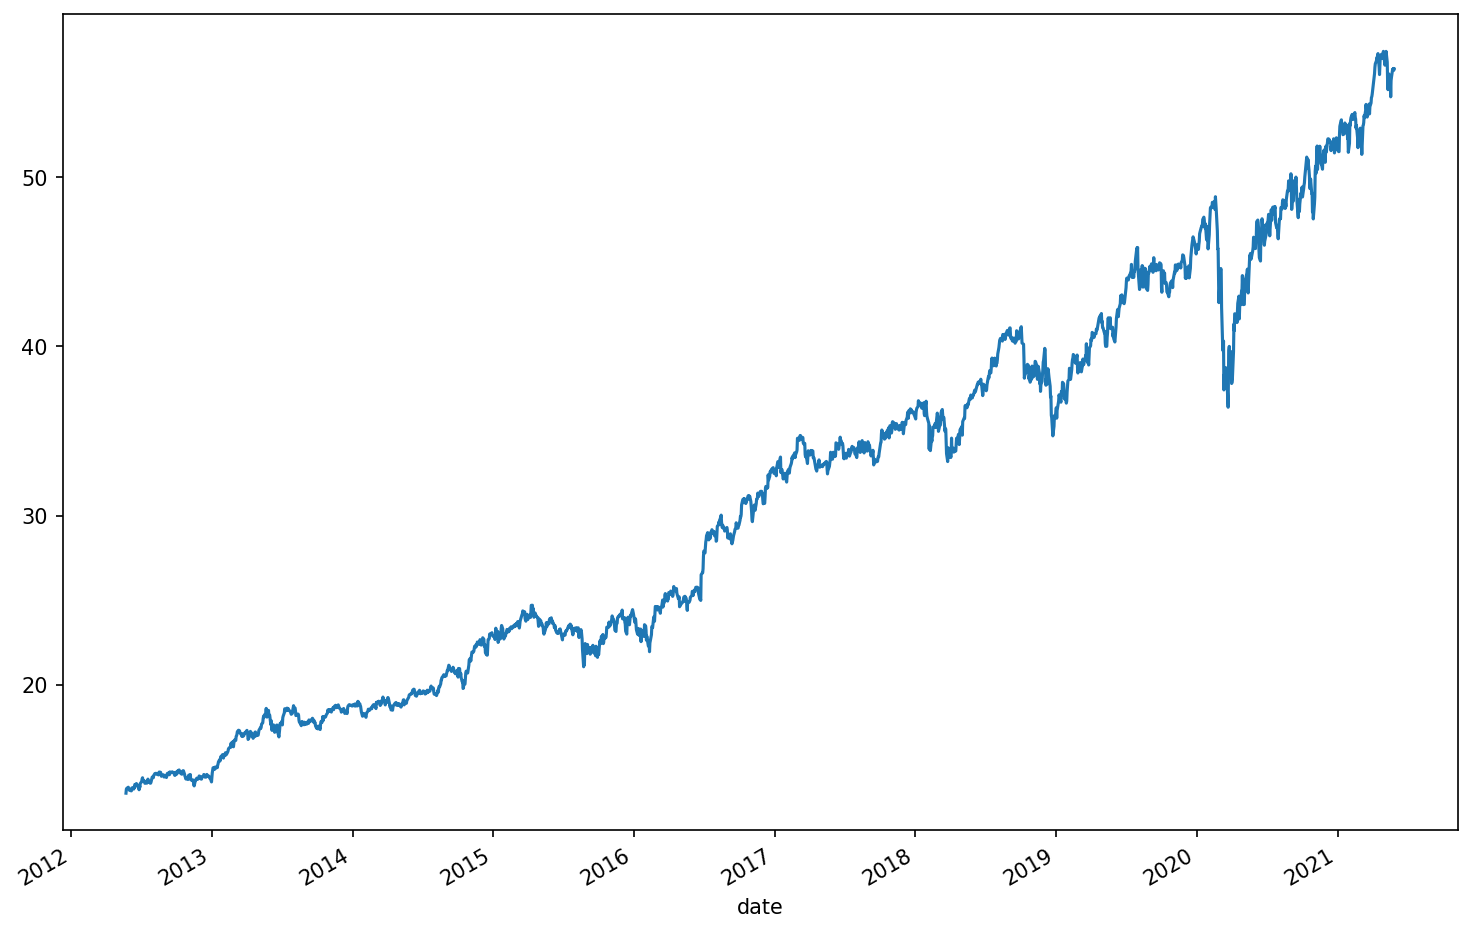

In [24]:
df['adjusted_close'].plot()

In [25]:
data = extract_valid_daily_changes(df, 'adjusted_close', business_dates)

In [26]:
np.mean(data)

0.0006752038916380039

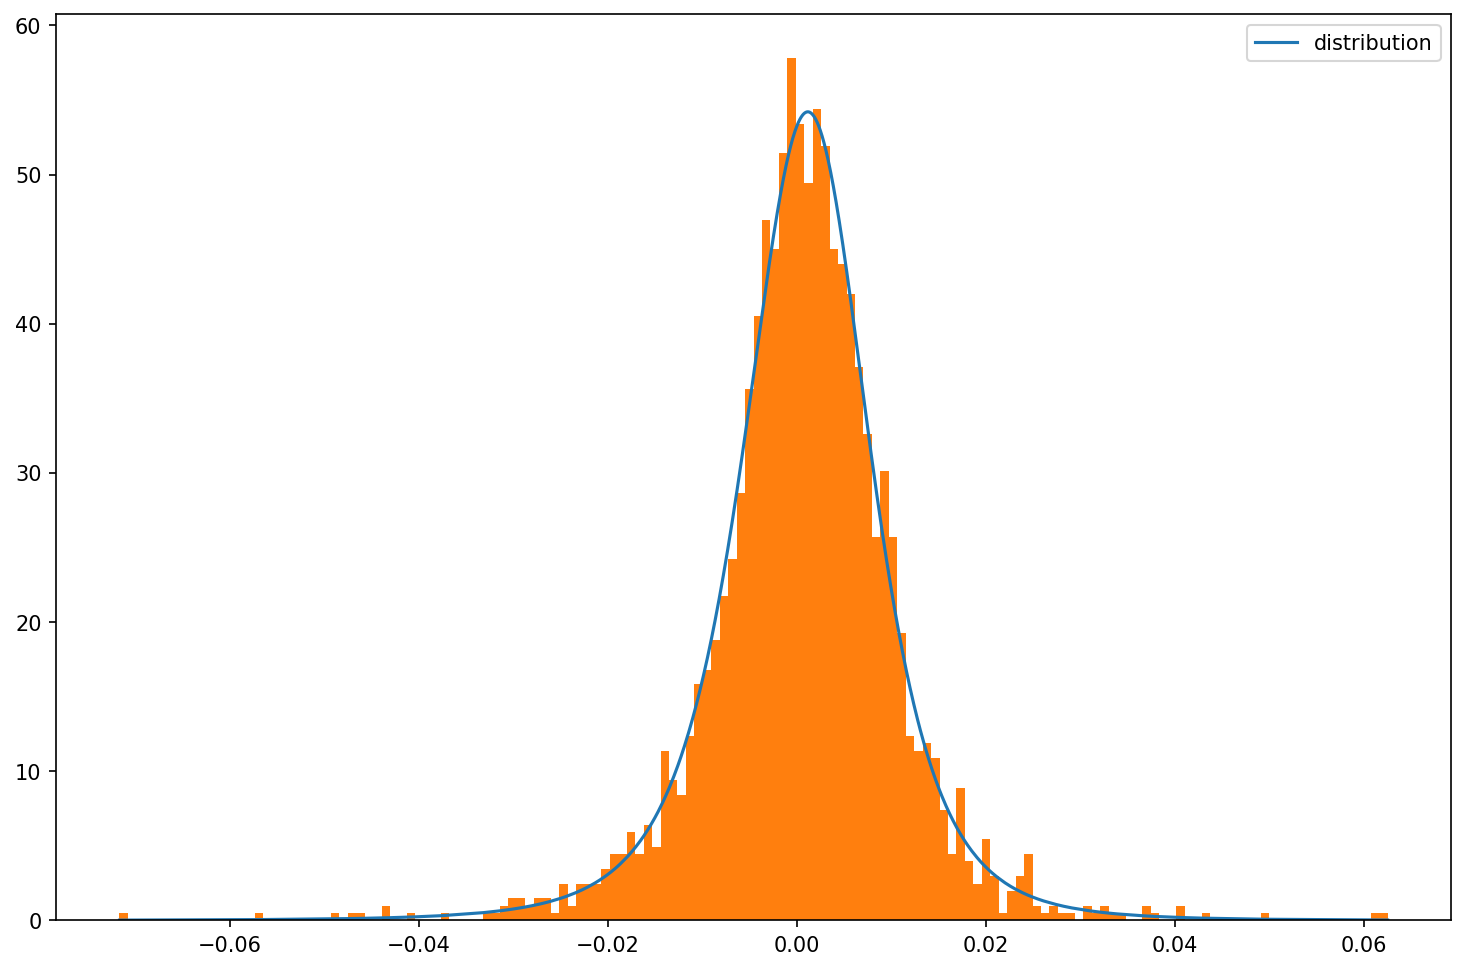

In [27]:
dist = getattr(stats, 'nct')
param = dist.fit(data)

# distribution
pdf = dist.pdf(data, *param)
plt.plot(data, pdf, label='distribution')

# Sample histogram
plt.hist(data, bins=150, density=True)

plt.legend();

In [28]:
pct_diff_dists = [
    'nct',
    'johnsonsu',
    'tukeylambda',
]

def get_dist_params(data):
    '''Loop through distributions and return parameters for best fit'''
    results = {}
    for i in pct_diff_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        pvalue = a[1]
        results[pvalue] = (dist(*param), param)
    return results[max(results.keys())]

etf_price_change_params = {}
for symbol in etf_screener.index:
    df = etf_historic_alpha[symbol]() 
    df.index = pd.to_datetime(df.date)
    data = extract_valid_daily_changes(df, 'adjusted_close', business_dates)
    etf_price_change_params[symbol] = get_dist_params(data)

In [29]:
# Hack to add in cash
class Cash:
    def rvs(self, n):
        return np.zeros(n)
    
cash = {'Cash': (Cash(), _)}

In [30]:
valid_future_dates = business_dates[business_dates.index >= start].index  # Monday to Friday (4 weeks) - finishing on weekend

In [31]:
from collections import Counter

In [32]:
def simulate(params: Dict[str, tuple], divs: Dict[str, float], days: int = 20, n: int = 1_000_000):
    
    cnt = Counter(  # get count of max dist, per index
        np.argmax(  # index of maximum, per element (length: n)
            [ 
                (1 + dist.rvs(n * days)).reshape((n, days)).prod(axis=1) + (divs.get(symbol, 0))  # prod per days (length: n)
                for symbol, (dist, param) in  params.items()
            ], 
            axis=0
        )
    )
    
    symbol_map = {i: symbol for i, symbol in enumerate(params.keys())}
    
    return sorted([(symbol_map[key], value / n) for key, value in cnt.items()], key=lambda x: x[1], reverse=True)
    

In [33]:
def mean_expected_return(dist: Any, days: int = 20):
    return (dist.stats(moments='m') + 1) ** days

In [34]:
for symbol, (dist, _) in etf_price_change_params.items():
    etf_screener.loc[symbol, 'expected_return'] = mean_expected_return(dist, len(valid_future_dates))
    
# adjust for dividend (take yield divided by 13 which is 52 / 4 - needs adjusting if time changes)
etf_screener['expected_return'] = etf_screener['expected_return'] + etf_screener['dividend_yield'].fillna(0) / 13

In [35]:
etf_screener['expected_return']

symbol_alphavantage
S100.LON    1.002545
IUKD.LON    1.006171
VHYL.LON    1.013322
IKOR.LON    1.008018
IEEM.LON    1.009047
              ...   
HTRY.LON    0.992463
HSPX.LON    1.015146
XUKS.LON    0.994856
XSPS.LON    0.993121
XMRC.LON    1.008367
Name: expected_return, Length: 96, dtype: float64

In [36]:
def top_n(data: Iterable, n: int = 10):
    srt = sorted(data, key=lambda x: x[1], reverse=True)
    return [sym for sym, _ in srt][:n]

In [37]:
def is_dividend_upcoming(x):
    return (x >= start) & (x <= end)

In [38]:
exclusions = {'HSPX.LON', 'ISWD.LON'}

In [39]:
expected_returns = [(sym, x) for sym, x in etf_screener.expected_return.items() if sym not in exclusions]

In [40]:
S = simulate(
    dict(**{sym: etf_price_change_params[sym] for sym in top_n(expected_returns, n=10)}, **cash),
    etf_screener[is_dividend_upcoming(etf_screener['approx_next_dividend_date'])]['approx_next_dividend_pct'].to_dict(),
    days=len(valid_future_dates), 
    n=1_000_000
)

In [41]:
S

[('ROBG.LON', 0.161402),
 ('IFFF.LON', 0.134404),
 ('IWFM.LON', 0.120109),
 ('IAPD.LON', 0.106231),
 ('MIDD.LON', 0.103462),
 ('CNX1.LON', 0.099369),
 ('SMEA.LON', 0.072357),
 ('VMID.LON', 0.071378),
 ('VUSA.LON', 0.067773),
 ('VWRL.LON', 0.063462),
 ('Cash', 5.3e-05)]

In [42]:
# Correlation of all ETFs to determine high correlation - probably don't want highly correlated ETFs or stocks
# Figure out how to use PE ratio or dividends to create separate distributions

In [415]:
df = etf_historic_alpha['ISF.LON']()
df.index = pd.to_datetime(df.date)

In [429]:
df['LSMA500'] = df['adjusted_close'].rolling(window=500).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,500)), x, 1), x=499) , raw=True)
df['LSMA200'] = df['adjusted_close'].rolling(window=200).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,200)), x, 1), x=199) , raw=True)
df['LSMA100'] = df['adjusted_close'].rolling(window=100).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,100)), x, 1), x=99) , raw=True)
df['LSMA10'] = df['adjusted_close'].rolling(window=10).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,10)), x, 1), x=9) , raw=True)
df['LSMA50'] = df['adjusted_close'].rolling(window=50).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,50)), x, 1), x=49) , raw=True)


<AxesSubplot:xlabel='date'>

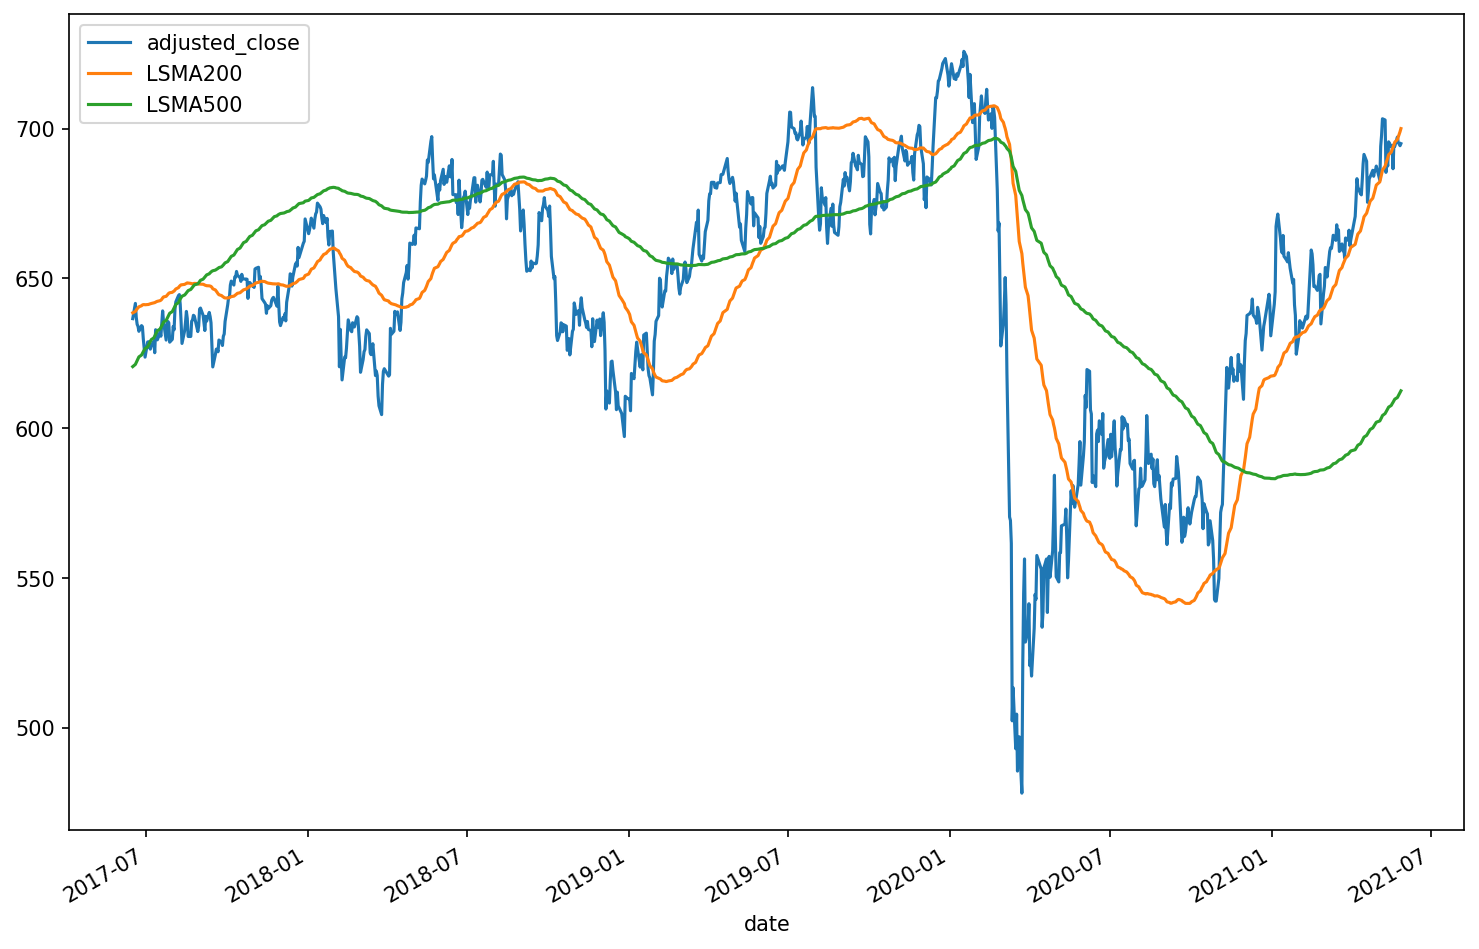

In [430]:
df[['adjusted_close', 'LSMA200', 'LSMA500']][-1000:].plot()

In [289]:
df_under = df[df.adjusted_close < df.LSMA500]
df_over  = df[df.adjusted_close > df.LSMA500] 

under 0.9971163092118682 1907
over 1.014790031073883 1526
all 1.0057320400336585 4137


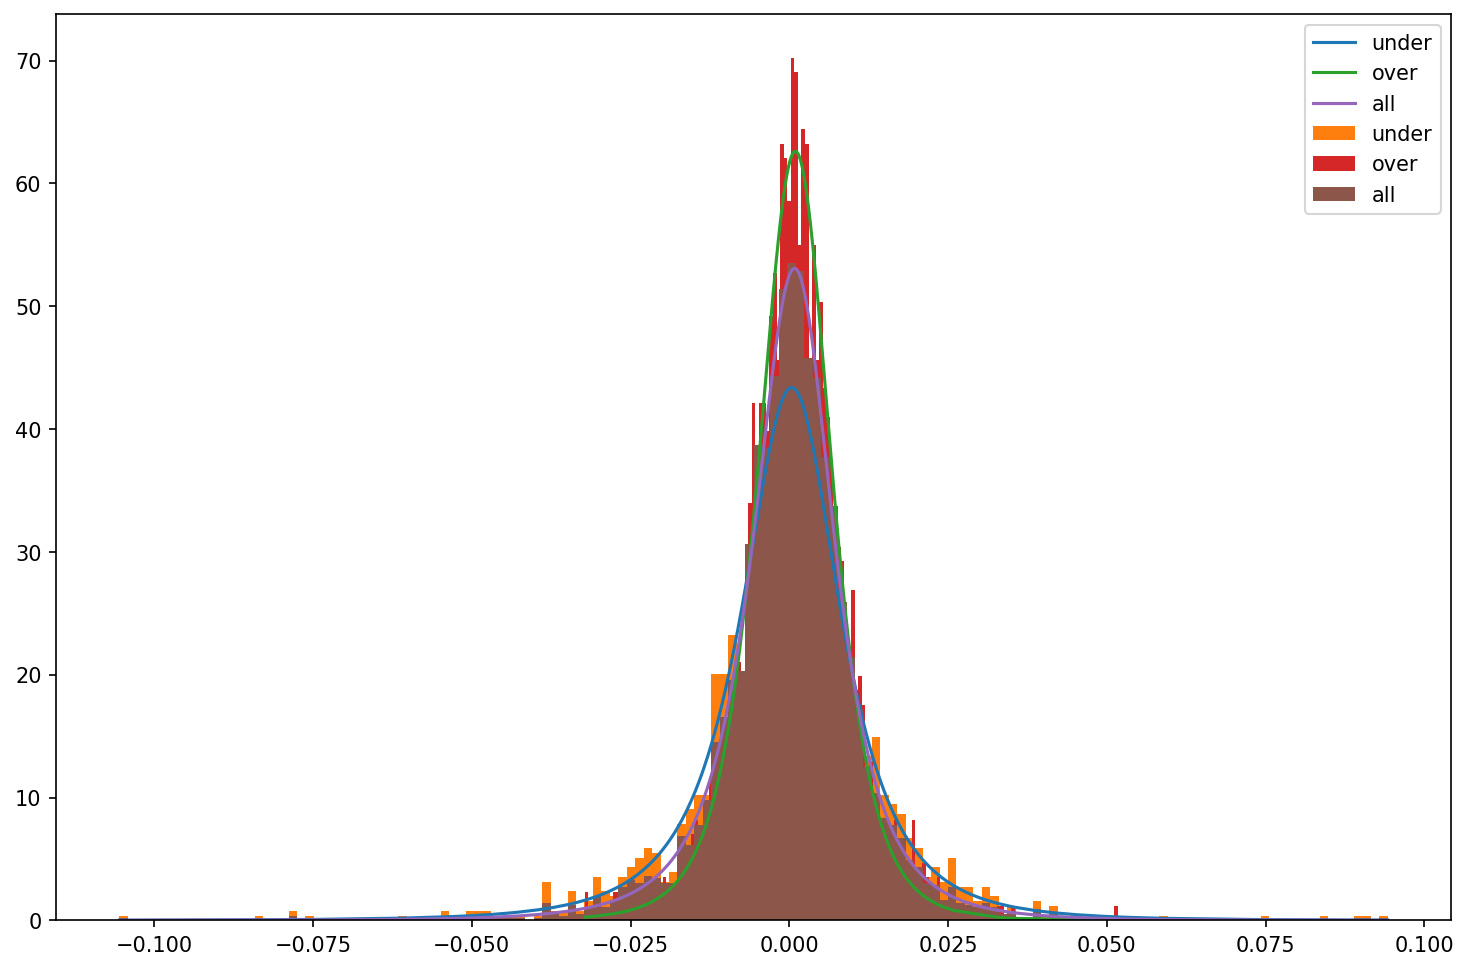

In [290]:
pct_diff_dists = [
    'nct',
    'johnsonsu',
    'tukeylambda',
    't'
]

def get_dist_params(data):
    '''Loop through distributions and return parameters for best fit'''
    results = {}
    for i in pct_diff_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        pvalue = a[1]
        results[pvalue] = (dist(*param), param)
    return results[max(results.keys())]

etf_price_change_params = {}
for name, ts in [('under', df_under), ('over', df_over), ('all', df)]:
    data = extract_valid_daily_changes(ts, 'adjusted_close', business_dates)
    param = get_dist_params(data)
    etf_price_change_params[name] = param
    
    print(name, mean_expected_return(param[0]), len(data))
    
    # distribution
    pdf = param[0].pdf(data)
    plt.plot(data, pdf, label=name)

    # Sample histogram
    plt.hist(data, bins=150, density=True, label=name)

    plt.legend();

In [229]:
# create list of filtered symbols
filtered_symbols = [sym for sym, x in etf_screener.expected_return.items() if sym not in exclusions and x > 1]

In [230]:
# check which ETFs are above and below the LSMA500, calculating relevant distribution

for symbol in filtered_symbols:

    df = etf_historic_alpha[symbol]()    
    df.index = pd.to_datetime(df.date)
    
    LSMA500 = df['adjusted_close'].rolling(window=500).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,500)), x, 1), x=499) , raw=True)
    
    if df.adjusted_close.iloc[-1] < LSMA500.iloc[-1]:
        data = extract_valid_daily_changes(df[df.adjusted_close < LSMA500], 'adjusted_close', business_dates)
    else:
        data = extract_valid_daily_changes(df[df.adjusted_close >= LSMA500], 'adjusted_close', business_dates)
    
    etf_price_change_params[symbol] = get_dist_params(data)
        

In [238]:
# get expected returns adjusted by LSMA500 threshold 
for symbol, (dist, _) in etf_price_change_params.items():
    etf_screener.loc[symbol, 'LSMA500_expected_return'] = mean_expected_return(dist, len(valid_future_dates))

# create expected returns dict for use in simulation
expected_returns = [(sym, x) for sym, x in etf_screener.LSMA500_expected_return.items() if sym in filtered_symbols]

In [248]:
S = simulate(
    dict(**{sym: etf_price_change_params[sym] for sym in top_n(expected_returns, n=50)}, **cash),
    etf_screener[is_dividend_upcoming(etf_screener['approx_next_dividend_date'])]['approx_next_dividend_pct'].to_dict(),
    days=len(valid_future_dates), 
    n=1_000_000
)

In [249]:
S

[('IBZL.LON', 0.142898),
 ('IKOR.LON', 0.060723),
 ('ITWN.LON', 0.05752),
 ('IEEM.LON', 0.041024),
 ('IDVY.LON', 0.034098),
 ('IUSP.LON', 0.033382),
 ('WOOD.LON', 0.032626),
 ('ISP6.LON', 0.031696),
 ('CUS1.LON', 0.030831),
 ('IPRV.LON', 0.029036),
 ('EUE.LON', 0.028367),
 ('EMIM.LON', 0.025955),
 ('IAPD.LON', 0.024786),
 ('IEUX.LON', 0.023242),
 ('IPRP.LON', 0.023073),
 ('VFEM.LON', 0.022316),
 ('IJPH.LON', 0.020239),
 ('MIDD.LON', 0.019699),
 ('IUKD.LON', 0.019202),
 ('IWDP.LON', 0.017683),
 ('IASP.LON', 0.017443),
 ('SEDY.LON', 0.016504),
 ('S100.LON', 0.016169),
 ('VAPX.LON', 0.015207),
 ('CS51.LON', 0.015075),
 ('CPJ1.LON', 0.014026),
 ('IGUS.LON', 0.011794),
 ('VERX.LON', 0.010961),
 ('HMXJ.LON', 0.010657),
 ('IUSA.LON', 0.010399),
 ('INAA.LON', 0.009093),
 ('IWRD.LON', 0.009058),
 ('USDV.LON', 0.008663),
 ('CSP1.LON', 0.008628),
 ('VNRT.LON', 0.008525),
 ('VUSA.LON', 0.008307),
 ('MVUS.LON', 0.008005),
 ('ISUS.LON', 0.007993),
 ('SMEA.LON', 0.007916),
 ('IH2O.LON', 0.007848),
 (

In [285]:
etf_price_change_params['over'][0].interval(0.9)

(-0.011335590737461205, 0.013135248345985421)

In [279]:
# this is only for a day
# what about the ma - would this be MA length?
# how extrapolate daily distribution to MA length

In [296]:
under_dist = etf_price_change_params['under'][0]
over_dist  = etf_price_change_params['over'][0]

In [295]:
n = 1_000_000
days = 20

In [297]:
under_sim = (1 + under_dist.rvs(n * days)).reshape((n, days)).prod(axis=1)
over_sim  = (1 + over_dist.rvs(n * days)).reshape((n, days)).prod(axis=1)

In [315]:
np.quantile(under_sim, 0.05) - 1

-0.10829617062478858

In [307]:
np.quantile(under_sim, 0.95) - 1

0.10587043308979616

In [308]:
np.quantile(over_sim, 0.95) - 1

0.07566405248310182

In [309]:
np.quantile(over_sim, 0.05) - 1

-0.04459335364049488

In [ ]:
# apply these quantiles to ISF LSMA and general price data
# plot these new upper and lower bounds

In [460]:
df.loc[df.LSMA500 > df.adjusted_close, 'lower_bound'] = (np.quantile(under_sim, 0.05) * df.LSMA10).shift(20)
df.loc[df.LSMA500 < df.adjusted_close, 'lower_bound'] = (np.quantile(over_sim, 0.05) * df.LSMA10).shift(20)
df.loc[df.LSMA500 > df.adjusted_close, 'upper_bound'] = (np.quantile(under_sim, 0.95) * df.LSMA100).shift(20)
df.loc[df.LSMA500 < df.adjusted_close, 'upper_bound'] = (np.quantile(over_sim, 0.95) * df.LSMA100).shift(20)

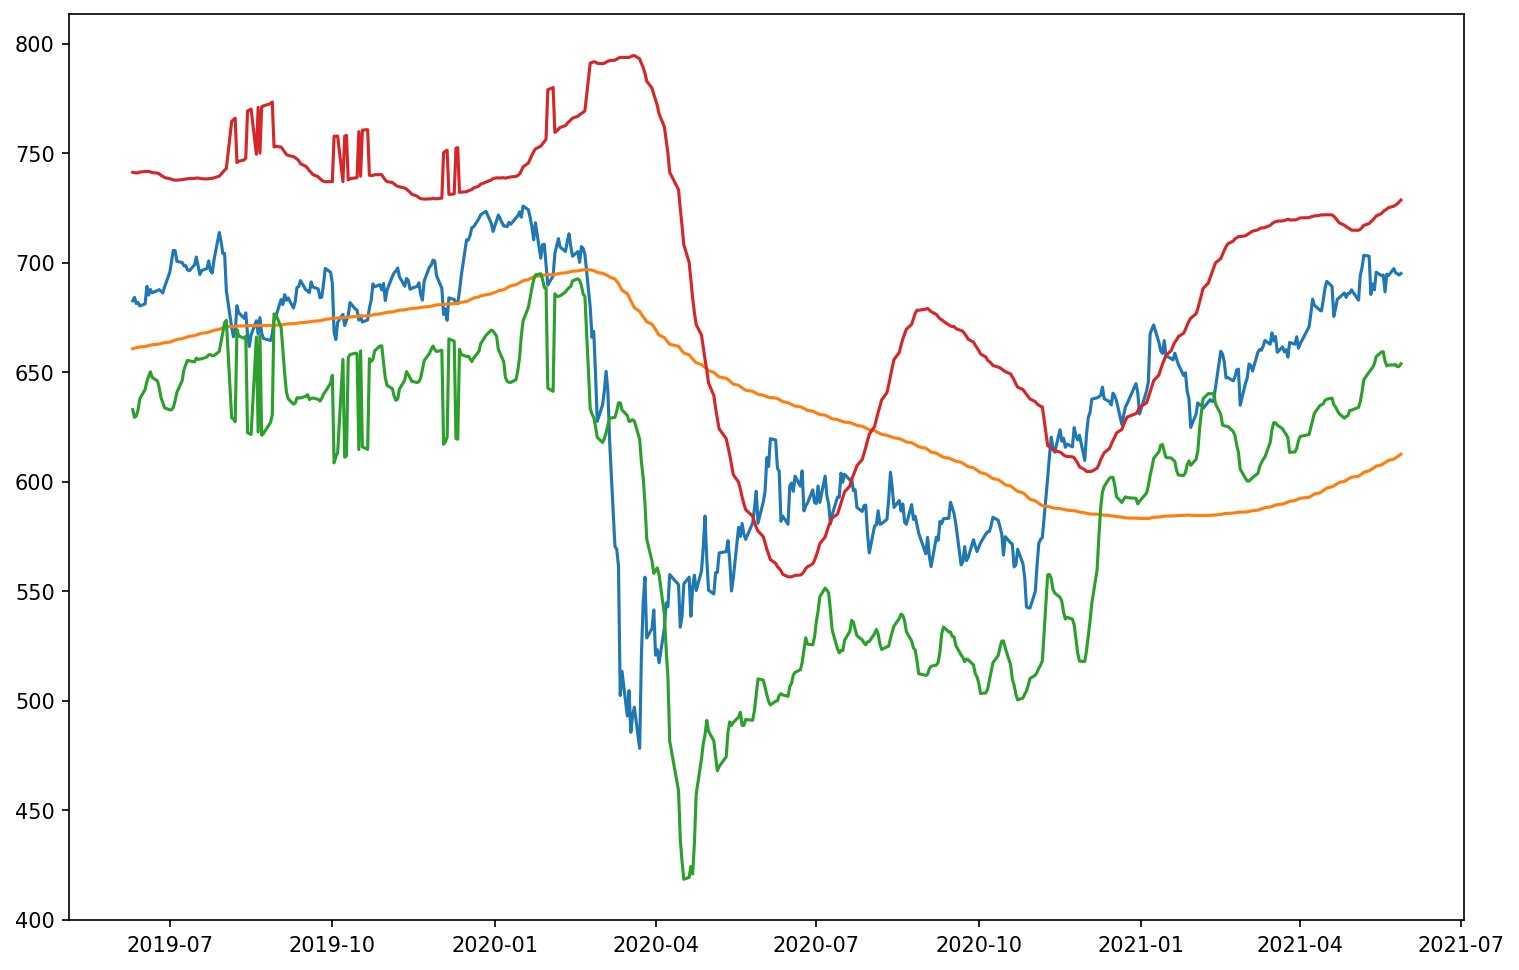

In [461]:
plt.plot(df[['adjusted_close', 'LSMA500', 'lower_bound', 'upper_bound']][-500:])